In [12]:
from typing import Tuple, List
from src import ipynb_display_images
from src.io import write_ppm, convert_ppm_to_png
from src.io.image_helper import image_to_ppm
from src.io.image_helper import ipnb_display_multiple_images_in_row, image_pipeline
from dataclasses import dataclass
from src.geometry.ray import Ray
from src import Vertex, Vector
from src.geometry.primitive import Primitive
from src.material.color import Color
import math
from src.render.resolution import Resolution

# Introduction to ray-tracing
In this notebook we will explore the basics of ray-tracing, a rendering technique used to generate realistic images by simulating the way light interacts with objects in a scene. We will cover the basics of ray-tracing step by step and implement a simple ray-tracer in python with use of library (this library, todo name it).


---
# NAVIGATION

<details>
<summary>Data representation</summary>

- What is color
- Image
- Pixel operations

</details>

<details>
<summary>Ray-tracing basics</summary>

- Camera
- Rays
- Intersection

</details>

---

# Data representation
### What is color and how represent it?

In computer graphics is color typically represented using the RGB color model, which is combination of red, green, and blue light. Each color channel is represented by integer values ranging from 0 to 255 or by
a float value ranging from 0.0 to 1.0, where 0.0 means no intensity and 1.0 means full intensity of that color channel. We will use float representation in this notebook for simplicity and ease of calculations.

![image](./edu_src/color.png)

## How to represent an image?
Before we dive into the implementation of a ray-tracer, let's first understand how we represent the colors we want to get for image pixels.
For simplicity, we will represent color data as RGB values stored in classic tuples of three floats ranging from 0.0 to 1.0.

And for our image, we will use 3 components:
- A list of colors (linear RGB tuples) representing the color of each pixel in the image.
- An integer representing the width of the image in pixels.
- An integer representing the height of the image in pixels.

---

## Let's implement this in code:
- color is represented as Tuple[float, float, float] for RGB values
- image is represented as Tuple[List[Color], int, int] for pixel colors, width and height

In [13]:
Image = Tuple[List[Color], int, int]
black = Color.linear_rgb(0.0, 0.0, 0.0)

def create_empty_image(width: int, height: int) -> Image:
    pixels = [black for _ in range(width * height)]
    return pixels, width, height


---

## Using our image representation
Now that we have our image representation ready, let's create a simple black image and display it using our image pipeline. To convert and display the image, we will use the following functions:
- `image_to_ppm`: Converts our image representation to PPM format and saves it to
- `convert_ppm_to_png`: Converts the PPM file to PNG format for better compatibility
- `ipynb_display_images`: Displays the PNG image in the Jupyter notebook
- or `image_pipeline`: A helper function to streamline the conversion and display process in one step

This functions are part of our library and can be found in `src/io/image_helper.py` for simplicity and clearness not all implementation details are shown here.

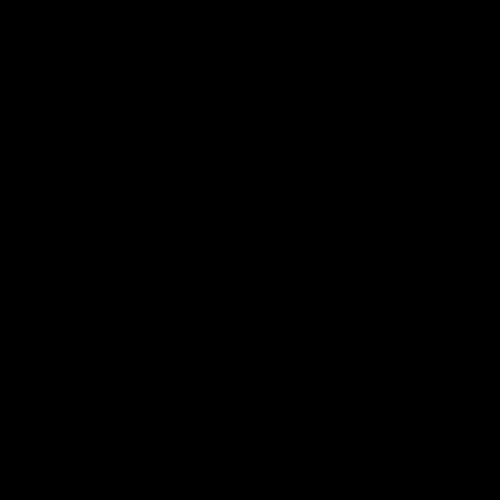

In [14]:
image = create_empty_image(500, 500)

image_to_ppm("black_image.ppm", image)
convert_ppm_to_png("black_image.ppm", "black_image.png")
ipynb_display_images("black_image.png")

---

## Setting pixel colors as gradient
Now we have a basic image representation, let's set the pixel colors to create a gradient effect. For X axis we will use red channel, for Y axis we will use green channel and for Z axis represent blue channel (which will be 0 in front and each next step will increase it to simulate depth using multiple layers).

In [15]:
def set_pixel_color(image: Image, x: int, y: int, color: Color) -> None:
    pixels, width, height = image
    if 0 <= x < width and 0 <= y < height:
        pixels[y * width + x] = color

In [16]:
images = []
image = create_empty_image(50, 50)

for z in range(50):
    for x in range(50):
        for y in range(50):
                r = x / 49.0
                g = y / 49.0
                b = z / 49.0
                set_pixel_color(image, x, y, Color.linear_rgb(r, g, b))
    images.append(image_pipeline(image, z))

ipnb_display_multiple_images_in_row(images, row_size=10)

---

## *What we have learned so far?*
- Color defined as RGB values (float representation)
- Image represented as list of colors with width and height
- How to render a simple gradient image by setting pixel colors based on their position in pseudo-3D space (x, y, z)

---

## *What you can try?*
- Create different color gradients by changing the way we calculate RGB values based on pixel position
- Experiment with different image sizes and see how it affects the gradient

---

# Ray-tracing basics

We have our plane image representation ready, now let's move on to the basics of ray-tracing by creating simple camera and casting rays into the scene.
- camera usually has position, look_at point, up vector and field of view
    - position: where the camera is located in 3D space
    - look_at: the point in 3D space the camera is looking at to define the viewing direction (plane normal)
    - up: the up direction for the camera to define its orientation
    - fov: field of view, which defines how wide the camera can see (in radians or degrees we will use degrees here)

In [17]:
@dataclass
class Camera:
    origin: Vertex
    direction: Vector
    up_hint: Vector
    fov_deg: float
    aspect_ratio: float

    def __post_init__(self):
        # Build an orthonormal camera basis
        self.forward = self.direction.normalize()
        self.right = self.forward.cross(self.up_hint).normalize()
        self.up = self.right.cross(self.forward).normalize()

        # Precompute viewport size on the image plane
        half_h = math.tan(math.radians(self.fov_deg) * 0.5)
        half_w = half_h * self.aspect_ratio

        self.horizontal = self.right * (2.0 * half_w)
        self.vertical   = self.up    * (2.0 * half_h)
        self.lower_left = (
            self.origin
            + self.forward
            - self.horizontal * 0.5
            - self.vertical * 0.5
        )

    def make_ray(self, u: float, v: float) -> Ray:
        """
        u,v in [0,1]
        u=0 left, u=1 right
        v=0 bottom, v=1 top
        """
        pixel_pos = self.lower_left + self.horizontal * u + self.vertical * v
        direction = (pixel_pos - self.origin).normalize()
        return Ray(self.origin, direction)

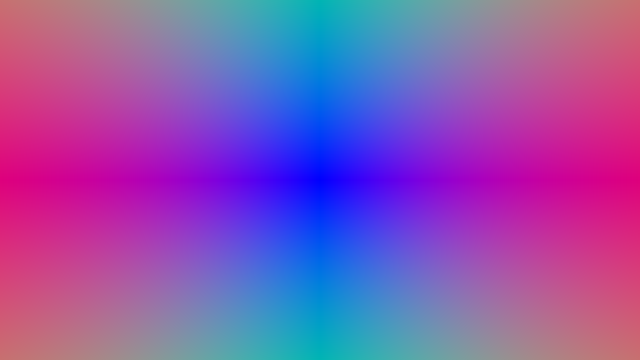

In [18]:
camera = Camera(
    origin=Vertex(0, 0, 0),
    direction=Vector(0, 0, -1),
    up_hint=Vector(0.0, 1.0, 0.0),
    fov_deg=90.0,
    aspect_ratio=Resolution.R360p.aspect_ratio
)

# Cast rays for each pixel in the image
width, height = Resolution.R360p
image = create_empty_image(width, height)

for y in range(height):
    for x in range(width):
        u = x / (width - 1)
        v = y / (height - 1)

        ray = camera.make_ray(u, v)

        r = abs(ray.direction.x) % 1.0
        g = abs(ray.direction.y) % 1.0
        b = abs(ray.direction.z) % 1.0

        set_pixel_color(image, x, y, Color.linear_rgb(r, g, b))


ipynb_display_images(image_pipeline(image))


# Render loop explanation
We created simple render loop above but we dont want to make him every time from scratch so let's explain it step by step and create a reusable one:

In [19]:
from src.scene.object import Object


def shade(ray: Ray, objects: List[Object] | None) -> Color:
    for obj in objects or []:
        hit = obj.geometry.intersect(ray)
        if hit is not None:
            return obj.material.get_color()

    return black

@dataclass
class SimpleRayTraceLoop:
    camera: Camera
    width: int
    height: int
    objects: List[Object] = None

    def render(self) -> Image:
        image = create_empty_image(self.width, self.height)

        for y in range(self.height):
            for x in range(self.width):
                u = x / (self.width - 1)
                v = y / (self.height - 1)

                ray = self.camera.make_ray(u, v)
                color = shade(ray, objects=self.objects)

                set_pixel_color(image, x, y, color)

        return image

# Add object
Now that we have a basic ray-casting mechanism in place, let's add a simple object to our scene and implement ray-object intersection logic. We will start with a sphere.

In [20]:
from dataclasses import field
from src.geometry.geometry_hit import GeometryHit
from math import sqrt
from src import Material
from src.scene.object import Object

@dataclass
class Sphere(Primitive):
    center: Vertex
    radius: float

    def intersect(self, ray: Ray, t_min=0.001, t_max=float('inf')) -> GeometryHit | None:
        """
        Calculate intersection of ray with sphere.
        :param ray: Ray to test intersection with
        :param t_min: minimum valid distance for intersection
        :param t_max: maximum valid distance for intersection
        :return: Hit record if intersection occurs, else None
        """
        oc = ray.origin - self.center  # Vector from oray origin to sphere center

        # Quadratic coefficients
        a = ray.direction.dot(ray.direction)  # Usually = 1 if ray.direction is normalized
        b = 2.0 * oc.dot(ray.direction)  # Projection of oc onto the ray
        c = oc.dot(oc) - self.radius * self.radius  # Distance^2 from ray origin to sphere surface

        discriminant = b * b - 4 * a * c
        if discriminant < 0:
            return None  # no intersection - ray misses the sphere

        sqrt_disc = sqrt(discriminant)

        # Find the nearest root that lies in the acceptable range by calculating both roots using quadratic formula
        root = (-b - sqrt_disc) / (2.0 * a)
        if root < t_min or root > t_max:
            root = (-b + sqrt_disc) / (2.0 * a)
            if root < t_min or root > t_max:  # Point is out of range so no valid intersection
                return None

        # Calculate intersection in 3d space
        hit_point = ray.point_at(root)

        # Calculate normal at the intersection point for lighting calculations
        normal = self.normal_at(hit_point)
        if ray.direction.dot(normal) > 0.0:
            normal = -normal

        front_face = ray.direction.dot(normal) < 0.0

        return GeometryHit(
            dist=root,
            point=hit_point,
            normal=normal,
            front_face=front_face
        )


    def normal_at(self, point: Vertex) -> Vector:
        """
        Get the normal vector at a given point on the sphere's surface.
        :param point: Point on the sphere
        :return: Normal vector at that point
        """
        normal = (point - self.center) / self.radius
        return normal

@dataclass
class ColorMaterial(Material):
    color: Color = field(default_factory=lambda: Color.custom_rgb(255, 255, 255))
    def get_color(self) -> Color:
        return self.color

## Ray-sphere intersection
Now that we have our sphere class defined, let's implement the ray-sphere intersection logic in our ray-tracer.

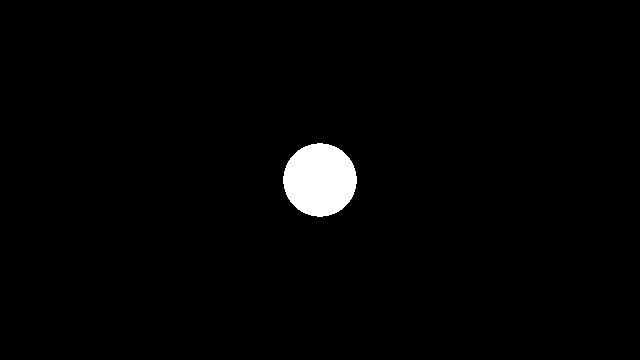

In [21]:
white_sphere = Object(
    geometry=Sphere(center=Vertex(0, 0, -5), radius=1.0),
    material=ColorMaterial(color=Color(1.0, 1.0, 1.0))
)

width, height = Resolution.R360p

ray_trace_loop = SimpleRayTraceLoop(camera=camera, width=width, height=height, objects=[white_sphere])
image = ray_trace_loop.render()
ipynb_display_images(image_pipeline(image))

# Let's import more objects
Import more objects and create a scene with multiple spheres

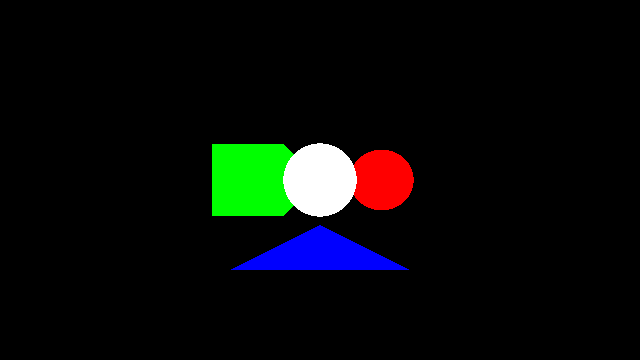

In [22]:
from src.geometry.primitives import Box, Triangle, Sphere, Plane, Cylinder

red_sphere = Object(
    geometry=Sphere(center=Vertex(2, 0, -6), radius=1.0),
    material=ColorMaterial(color=Color(1.0, 0.0, 0.0))
)

green_box = Object(
    geometry=Box(
        corner1=Vertex(-3, -1, -7),
        corner2=Vertex(-1, 1, -5)
    ),
    material=ColorMaterial(color=Color(0.0, 1.0, 0.0))
)

blue_triangle = Object(
    geometry=Triangle(
        v0=Vertex(-2, 2, -4),
        v1=Vertex(0, 1, -4),
        v2=Vertex(2, 2, -4)
    ),
    material=ColorMaterial(color=Color(0.0, 0.0, 1.0))
)


ray_trace_loop = SimpleRayTraceLoop(
    camera=camera,
    width=width,
    height=height,
    objects=[white_sphere, red_sphere, green_box, blue_triangle]
)

image = ray_trace_loop.render()
ipynb_display_images(image_pipeline(image))
